In [3]:
import os
import pandas as pd

print(len(os.listdir("test_data/sp500")))
# iterate over all csv files in test_data/sp500 folder
for file in os.listdir("test_data/sp500"):
    if file.endswith(".csv"):
        # read csv file
        df = pd.read_csv(f"test_data/sp500/{file}", header=[0,1], index_col=0)
        # get ticker symbol from the header
        ticker = df.columns.levels[1][0]
        if df.empty:
            # add ticker to replacement list
            with open("replacement_list.csv", "a") as f:
                f.write(f"{ticker},\n")
            # remove file
            os.remove(f"test_data/sp500/{file}")

728


In [ ]:
import pandas as pd
import os

df_list = []
# iterate over all csv files in test_data/sp500 folder
for file in os.listdir("test_data/sp500"):
    if file.endswith(".csv"):
        # read csv file
        df = pd.read_csv(f"test_data/sp500/{file}", header=[0,1], index_col=0)
        df_list.append(df)

current_date = pd.to_datetime("1994-12-31").date()
today = pd.Timestamp.today().date()
date_dict = {}

# iterate over all csv files in test_data/sp500 folder
while current_date < today:
    current_date += pd.DateOffset(days=1)
    current_date = current_date.date()
    date_dict[current_date] = 0
    for df in df_list:
        file_start_date = df.index[0]
        file_end_date = df.index[-1]
        if pd.to_datetime(file_start_date).date() <= current_date <= pd.to_datetime(file_end_date).date():
            # search for an entry with the current date
            if current_date.strftime("%Y-%m-%d") in df.index:
                date_dict[current_date] += 1
    if date_dict[current_date] == 0:
        date_dict.pop(current_date)
    else:
        print(current_date)

# save date_dict to a csv file
df = pd.DataFrame(date_dict.items(), columns=["Date", "Count"])
df.to_csv("date_count.csv", index=False)

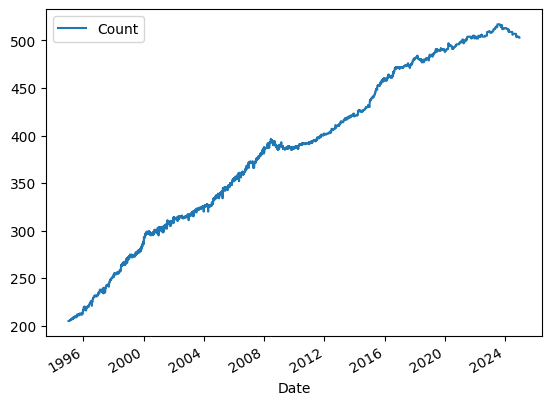

In [35]:
# plot date_count.csv
import matplotlib.pyplot as plt
df = pd.read_csv("date_count.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.plot()
plt.show()


In [32]:
# find the stock which has data on 2000-05-29

# iterate over all csv files in test_data/sp500 folder
for file in os.listdir("test_data/sp500"):
    if file.endswith(".csv"):
        # read csv file
        df = pd.read_csv(f"test_data/sp500/{file}", header=[0,1], index_col=0)
        if pd.to_datetime("2000-11-23").date().strftime("%Y-%m-%d") in df.index:
            print(file)
            break

1995-06-01_2004-03-24_TUP.csv


In [36]:
# remove all rows from 1995-01-02_2005-07-21_TOY.csv where data_count.csv has the value 1
import pandas as pd
df = pd.read_csv("test_data/sp500/1995-06-01_2004-03-24_TUP.csv", header=[0,1], index_col=0)
df2 = pd.read_csv("date_count.csv", index_col=0, header=[0])
df2.index = pd.to_datetime(df2.index)
df2 = df2[df2["Count"] < 10]
df2 = df2.index.strftime("%Y-%m-%d").tolist()
print(df2)
df = df.drop(df2, errors="ignore")
df.to_csv("test_data/1995-06-01_2004-03-24_TUP.csv")


[]


In [ ]:
# calculate stock price breadth
import pandas as pd
import os
from sys import exit

df_list = []
# iterate over all csv files in test_data/sp500 folder
for file in os.listdir("test_data/sp500"):
    if file.endswith(".csv"):
        # read csv file
        df = pd.read_csv(f"test_data/sp500/{file}", header=[0,1], index_col=0)
        file_start_date = file.split("_")[0]
        file_start_date = pd.to_datetime(file_start_date).date() + pd.DateOffset(days=365)
        # remove all rows before 1 year from the start date
        df = df[df.index >= file_start_date.strftime("%Y-%m-%d")]
        df_list.append(df)

# Process each ticker
for df in df_list:
    # Calculate the daily price change
    df['Change'] = df['Adj Close'].diff()
    
    # Define volumes for "up" and "down" days
    df['Volume Up'] = df['Volume'].where(df['Change'] > 0, 0)  # Volume for "up" days
    df['Volume Down'] = df['Volume'].where(df['Change'] < 0, 0)  # Volume for "down" days

# Combine all tickers' data
combined_breadth = pd.concat(df_list).groupby(level=0).sum()
#TODO check if the sum is actually correct
# Calculate total breadth
res = combined_breadth['Volume Up'] / (combined_breadth['Volume Down'] + combined_breadth['Volume Up'])
res.fillna(0.5, inplace=True)
res = pd.DataFrame(res, columns=['Breadth Ratio'], index=combined_breadth.index)
res.to_csv("breadth_ratio2.csv")

In [17]:
# plot breadth_ratio and breadth_ratio2 in one graph
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import utils
matplotlib.use('tkagg')

df2 = pd.read_csv("breadth_ratio2.csv", index_col=0)
df2.index = pd.to_datetime(df2.index)
# moving average
#plt.plot(utils.normalize_tanh(df2.ewm(span=10).mean(), steepness=7, shift=-0.5), color='red')
plt.plot(utils.normalize_tanh(df2.ewm(span=100, min_periods=50).mean() * 100, steepness=0.3, shift=-50), color='red')
plt.show()

In [41]:
def comp(row):
    pre = "a" if len(row.split(",")[1].strip()) > 0 else "b"
    return pre + "zzzzz" + row.split(",")[0].lower()

row_set = set()
with open("replacement_list.csv", "r") as f:
    for line in f:
        row_set.add(line)

with open("replacement_list2.csv", "w") as f:
    for row in sorted(row_set, key=comp):
        f.write(row)

In [ ]:
import os
import pandas as pd

# df_list = []
# # iterate over all csv files in test_data/sp500 folder
# for file in os.listdir("test_data/sp500"):
#     if file.endswith(".csv"):
#         # read csv file
#         df = pd.read_csv(f"test_data/sp500/{file}", header=[0,1], index_col=0)
#         file_start_date = file.split("_")[0]
#         file_start_date = pd.to_datetime(file_start_date).date() + pd.DateOffset(days=365)
#         # remove all rows before 1 year from the start date
#         df = df[df.index >= file_start_date.strftime("%Y-%m-%d")]
#         df_list.append(df)

# # concat all dataframes while keeping nan values
# combined_breadth = pd.concat(df_list, axis=1, join='outer')
combined_breadth = pd.read_csv("combined_breadth.csv", index_col=0, header=[0,1])
data_adj_close = combined_breadth.xs('Adj Close', axis=1, level=0)
# fill any nans after the first valid value but before the last valid value
# Identify the indices to forward-fill
ffill_mask = data_adj_close.notna() | data_adj_close.bfill().notna()
# Forward-fill the data
data_adj_close = data_adj_close.ffill().where(ffill_mask)
# period is the number of days to look back for a 52 week high
# 1. Calculate the 52 week highs and lows
year_highs = data_adj_close.rolling(window=252, min_periods=1).max()
year_lows = data_adj_close.rolling(window=252, min_periods=1).min()
# 2. Calculate the high and low of the last period days
period_highs = data_adj_close.rolling(window=10, min_periods=1).max()
period_lows = data_adj_close.rolling(window=10, min_periods=1).min()
# 3. Calculate the number of stocks that are at their 52 week high and low
num_highs = ((data_adj_close == period_highs) & (data_adj_close == year_highs)).sum(axis=1)
num_lows = ((data_adj_close == period_lows) & (data_adj_close == year_lows)).sum(axis=1)
# 4. Calculate the stock price strength
stock_price_strength = num_highs / (num_highs + num_lows) * 100
# replace NaN values with 50 (no stocks at 52 week high or low)
stock_price_strength.fillna(50, inplace=True)
df = pd.DataFrame((num_highs, num_lows, stock_price_strength), index=["Num Highs", "Num Lows", "Stock Price Strength"]).T
df

## Stock Price Strength

In [4]:
from sys import exit
import pandas as pd
import os
import yfinance as yf
# the number of days to look back for a high or low to count
period = 14
num_highs = {}
num_lows = {}
if not os.path.exists("test_data/trading_days.csv"):
    yf.download("^GSPC", start="1995-01-01").to_csv("test_data/trading_days.csv")
trading_days = pd.read_csv("test_data/trading_days.csv", index_col=0, header=[0,1])
trading_days.index = pd.to_datetime(trading_days.index)
for date in trading_days.index:
    num_highs[date] = 0
    num_lows[date] = 0
# iterate over all csv files in test_data/sp500 folder
for file in os.listdir("test_data/sp500"):
    if file.endswith(".csv"):
        # read csv file
        df = pd.read_csv(f"test_data/sp500/{file}", header=[0,1], index_col=0, parse_dates=True)["Adj Close"]
        df.index = pd.to_datetime(df.index)
        file_start_date = file.split("_")[0]
        actual_start_date = pd.to_datetime(file_start_date).date() + pd.DateOffset(days=365)
        # add all trading days that are missing in the dataframe
        df = df.reindex(trading_days.index, axis=0)
        # Identify the indices to forward-fill
        ffill_mask = df.notna() | df.bfill().notna()
        # Forward-fill the data
        df = df.ffill().where(ffill_mask)
        df.dropna(inplace=True)
        # get row that is after actual_start_date
        first_valid_row = df[df.index >= actual_start_date].iloc[0]
        year_high = df.loc[df[df.index <= first_valid_row.name].idxmax()].iloc[0]
        year_low = df.loc[df[df.index <= first_valid_row.name].idxmin()].iloc[0]
        current_row_index = df.index.get_loc(first_valid_row.name)
        current_row = first_valid_row
        while current_row_index < len(df) - 1 and current_row.notna().all():
            if current_row.iloc[0] >= year_high.iloc[0]:
                year_high = current_row
            elif current_row.iloc[0] <= year_low.iloc[0]:
                year_low = current_row
            else:
                one_year_ago = current_row.name - pd.DateOffset(days=365)
                if year_high.name < one_year_ago:
                    # calculate year_high again where the date is less than one year ago from the current date
                    year_high = df.loc[df[(df.index >= one_year_ago) & (df.index <= current_row.name)].idxmax()].iloc[0]
                if year_low.name < one_year_ago:
                    # calculate year_low again
                    year_low = df.loc[df[(df.index >= one_year_ago) & (df.index <= current_row.name)].idxmin()].iloc[0]
            if current_row.name - pd.DateOffset(days=period) <= year_high.name:
                num_highs[current_row.name] += 1
            if current_row.name - pd.DateOffset(days=period) <= year_low.name:
                num_lows[current_row.name] += 1
            current_row_index += 1
            current_row = df.iloc[current_row_index]
        # TODO try percentage to low or high (e.g. (high - low)*0.2 distance (20 low, 70 high -> 20-30 low 60-70 high), 20 low 25 high > 20-21 low 24-25 high)
        #compare with price_strength1.csv and price_strength2.csv

In [7]:
from sys import exit
import pandas as pd
import os
import yfinance as yf
num_highs = {}
num_lows = {}
if not os.path.exists("test_data/trading_days.csv"):
    yf.download("^GSPC", start="1995-01-01").to_csv("test_data/trading_days.csv")
trading_days = pd.read_csv("test_data/trading_days.csv", index_col=0, header=[0,1])
trading_days.index = pd.to_datetime(trading_days.index)
for date in trading_days.index:
    num_highs[date] = 0
    num_lows[date] = 0
# iterate over all csv files in test_data/sp500 folder
for file in os.listdir("test_data/sp500"):
    if file.endswith(".csv"):
        # read csv file
        df = pd.read_csv(f"test_data/sp500/{file}", header=[0,1], index_col=0, parse_dates=True)["Adj Close"]
        df.index = pd.to_datetime(df.index)
        file_start_date = file.split("_")[0]
        actual_start_date = pd.to_datetime(file_start_date).date() + pd.DateOffset(days=365)
        # add all trading days that are missing in the dataframe
        df = df.reindex(trading_days.index, axis=0)
        # Identify the indices to forward-fill
        ffill_mask = df.notna() | df.bfill().notna()
        # Forward-fill the data
        df = df.ffill().where(ffill_mask)
        df.dropna(inplace=True)
        # get row that is after actual_start_date
        first_valid_row = df[df.index >= actual_start_date].iloc[0]
        year_high = df.loc[df[df.index <= first_valid_row.name].idxmax()].iloc[0]
        year_low = df.loc[df[df.index <= first_valid_row.name].idxmin()].iloc[0]
        current_row_index = df.index.get_loc(first_valid_row.name)
        current_row = first_valid_row
        while current_row_index < len(df) - 1 and current_row.notna().all():
            if current_row.iloc[0] >= year_high.iloc[0]:
                year_high = current_row
            elif current_row.iloc[0] <= year_low.iloc[0]:
                year_low = current_row
            else:
                one_year_ago = current_row.name - pd.DateOffset(days=365)
                if year_high.name < one_year_ago:
                    # calculate year_high again where the date is less than one year ago from the current date
                    year_high = df.loc[df[(df.index >= one_year_ago) & (df.index <= current_row.name)].idxmax()].iloc[0]
                if year_low.name < one_year_ago:
                    # calculate year_low again
                    year_low = df.loc[df[(df.index >= one_year_ago) & (df.index <= current_row.name)].idxmin()].iloc[0]
            if current_row.iloc[0] >= year_high.iloc[0] - (year_high.iloc[0] - year_low.iloc[0]) * 0.2:
                num_highs[current_row.name] += 1
            if current_row.iloc[0] <= year_low.iloc[0] + (year_high.iloc[0] - year_low.iloc[0]) * 0.2:
                num_lows[current_row.name] += 1
            current_row_index += 1
            current_row = df.iloc[current_row_index]
        # TODO try percentage to low or high (e.g. (high - low)*0.2 distance (20 low, 70 high -> 20-30 low 60-70 high), 20 low 25 high > 20-21 low 24-25 high)
        #compare with price_strength1.csv and price_strength2.csv

In [8]:
df = pd.DataFrame((num_highs, num_lows), index=["Num Highs", "Num Lows"]).T
df["Strength"] = df["Num Highs"] / (df["Num Highs"] + df["Num Lows"]) * 100
df.to_csv("price_strength4.csv")

## Stock Price Breadth

1. do not count unchanged price volumes
2. test if pd.concat works correctly (missing values, ranges, zeros, etc.)